**A cat or a dog?**

**The objective of this project is to develop a model capable of distinguishing between images of cats and dogs.** 

The project is commissioned by the municipal authorities responsible for monitoring homeless animals on the streets. Several models have been developed for this purpose:

- An artificial neural network,

- A convolutional neural network with various modifications, including the application of SGD and Adam optimizers, adjustments to the number of epochs, incorporation of dropout layers and utilization of Data Augmentation techniques,

- Transfer learning using pre-trained models such as MobileNet V2, MobileNet V3 Large and VGG16.

The architecture of the convolutional neural network includes:

- Four convolutional layers, each containing 400 neurons and utilizing ReLU as the activation function (kernel size 3x3),

- One dense layer with 400 neurons and Sigmoid as the activation function,

- MaxPooling operations with a pool size of 2x2 and a stride of 2.

To monitor the progress of individual training sessions, the wandb tool has been empoloyed. Furthermore, to assess whether increasing the number of epochs would lead to improvements in model parameters while avoiding overfitting, I have implemented the EarlyStopping callback, with accuracy and validation loss serving as monitoring parameters. These measures have been instrumental in guiding decisions.

Except for training, validation, and testing accuracy, validation loss, precision, recall, and F1-score have been used as metrics for evaluating the models.

The experimentation process revealed that, currently, the most effective approach is to deploy the transfer learning model MobileNet V2. This model achieves a training accuracy of 99% and a testing accuracy of 94%. Nevertheless, there are still significant opportunities to explore other convolutional neural network architectures. These may involve adjustments to the network size, activation functions, and the number of neurons, among other parameters. These avenues hold promise for achieving satisfactory results and warrant further exploration.

In [79]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models

from wandb.keras import WandbMetricsLogger

In [3]:

data_1200 = "/home/kata/zajecia/ćwiczenia_python_moje/projekt_DL/data_1200"

train_dir_1200 = os.path.join(data_1200, 'training')
test_dir_1200 = os.path.join(data_1200, 'testing')
add_test_dir_1200 = os.path.join(data_1200, 'additional_testing')

Checking the connection with wandb, which will be used later to monitor the progress of the trainings.

In [4]:
!wandb login

wandb: Currently logged in as: katarzynakarwacka (xxxxxxxxxxxxxxxxxxxxxxx). Use `wandb login --relogin` to force relogin


Defining a function that loads images from the given directory and preprocesses the data. Images are resized and normalized.

In [5]:

def load_images(directory):
    images = []
    labels = []
    vectors = []
    label_encoder = LabelEncoder()
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):  
                img = Image.open(os.path.join(label_dir, filename))
                img = img.resize((150, 150)) 
                img = np.array(img) / 255.0  
                vector = img.flatten()
                #print(vector)
                #print(len(vector))
                #print(os.path.join(label_dir, filename))
                if len(vector) == 67500:
                  #np.array(vectors)
                  vectors.append(vector)
                  images.append(img)
                  labels.append(label) 
                #x = vector
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return np.array(images), np.array(vectors), labels


In [6]:
train_images_1200, train_vectors_1200, train_labels_1200 = load_images(train_dir_1200)
test_images_1200, test_vectors_1200, test_labels_1200 = load_images(test_dir_1200)


Defining a function that creates a CNN model

In [7]:
def create_cnn_model(inShape, convNum, hNum, hAct, loss, optimizer):
    """
    :param inShape: input shape, h*w*c
    :param convNum: list of the number of features (kernels) in convolutional layers
    :param hNum: list of the number of neurons in each hidden layer
    :param hAct: activation function, str
    :param loss: loss function
    """
  
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(inShape)))

    for _, oneConvNum in enumerate(convNum):

        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=3,
                                    strides=1,
                                    padding="SAME",
                                    activation="relu"
                                    )
                                )
 
        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )
 
    model.add(layers.Flatten())
   
    for _, oneHidNum in enumerate(hNum):
    
        model.add(layers.Dense(oneHidNum, activation=hAct))
 
    model.add(layers.Dense(1, activation='sigmoid'))

    print(model.summary())



    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"]
    )

    return model

Calling popular optimizations algorithms:

-- SGD (Stochastic Gradient Descent) -- it works by updating the parameters (weights) of the model in the direction that reduces the loss function, making it a gradient-based  optimization

-- Adam (Adaptive Moment Estimation) -- adaptive learning rates, often faster than SGD

In [8]:
opt_Adam = tf.keras.optimizers.Adam()
opt_SGD = tf.keras.optimizers.SGD()

As the images of cats and dogs are stored in separate folders, they are inherently ordered. To ensure a balanced distribution of cats and dogs images in the validation dataset, shuffling is necessary.

In [9]:
np.random.seed(42)
np.random.shuffle(test_images_1200)
np.random.seed(42)
np.random.shuffle(test_labels_1200)

shuffled_test_images = np.copy(test_images_1200)
shuffled_test_labels = np.copy(test_labels_1200)

SGD model with 0.01 learning rate, 4 conv layers and one hidden layer

In [10]:
CNN_1200_SGD = create_cnn_model(
    inShape= train_images_1200.shape[1:],
    convNum= [4,4,4,4],
    hNum = [400],
    hAct = 'relu',
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)

)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 4)         0

In [11]:
import wandb
run = wandb.init(
    project="CNN_project_SGD",
    config={
        "dataset": "cats and dogs images",
    },
)

historyCNN1200SGD = CNN_1200_SGD.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 10,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = WandbMetricsLogger(),

)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: katarzynakarwacka (xxxxxxxxxxxxxxxxxxxxxxx). Use `wandb login --relogin` to force relogin


Epoch 1/10
32/32 [==============================] - 7s 182ms/step - loss: 0.6941 - accuracy: 0.5075 - val_loss: 0.6925 - val_accuracy: 0.5067
Epoch 2/10
32/32 [==============================] - 9s 284ms/step - loss: 0.6937 - accuracy: 0.5005 - val_loss: 0.6922 - val_accuracy: 0.5467
Epoch 3/10
32/32 [==============================] - 7s 210ms/step - loss: 0.6934 - accuracy: 0.5125 - val_loss: 0.6918 - val_accuracy: 0.5267
Epoch 4/10
32/32 [==============================] - 9s 283ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6915 - val_accuracy: 0.5533
Epoch 5/10
32/32 [==============================] - 7s 213ms/step - loss: 0.6928 - accuracy: 0.5035 - val_loss: 0.6913 - val_accuracy: 0.5400
Epoch 6/10
32/32 [==============================] - 6s 190ms/step - loss: 0.6925 - accuracy: 0.5226 - val_loss: 0.6911 - val_accuracy: 0.5133
Epoch 7/10
32/32 [==============================] - 6s 180ms/step - loss: 0.6922 - accuracy: 0.5356 - val_loss: 0.6906 - val_accuracy: 0.5600
Epoch 

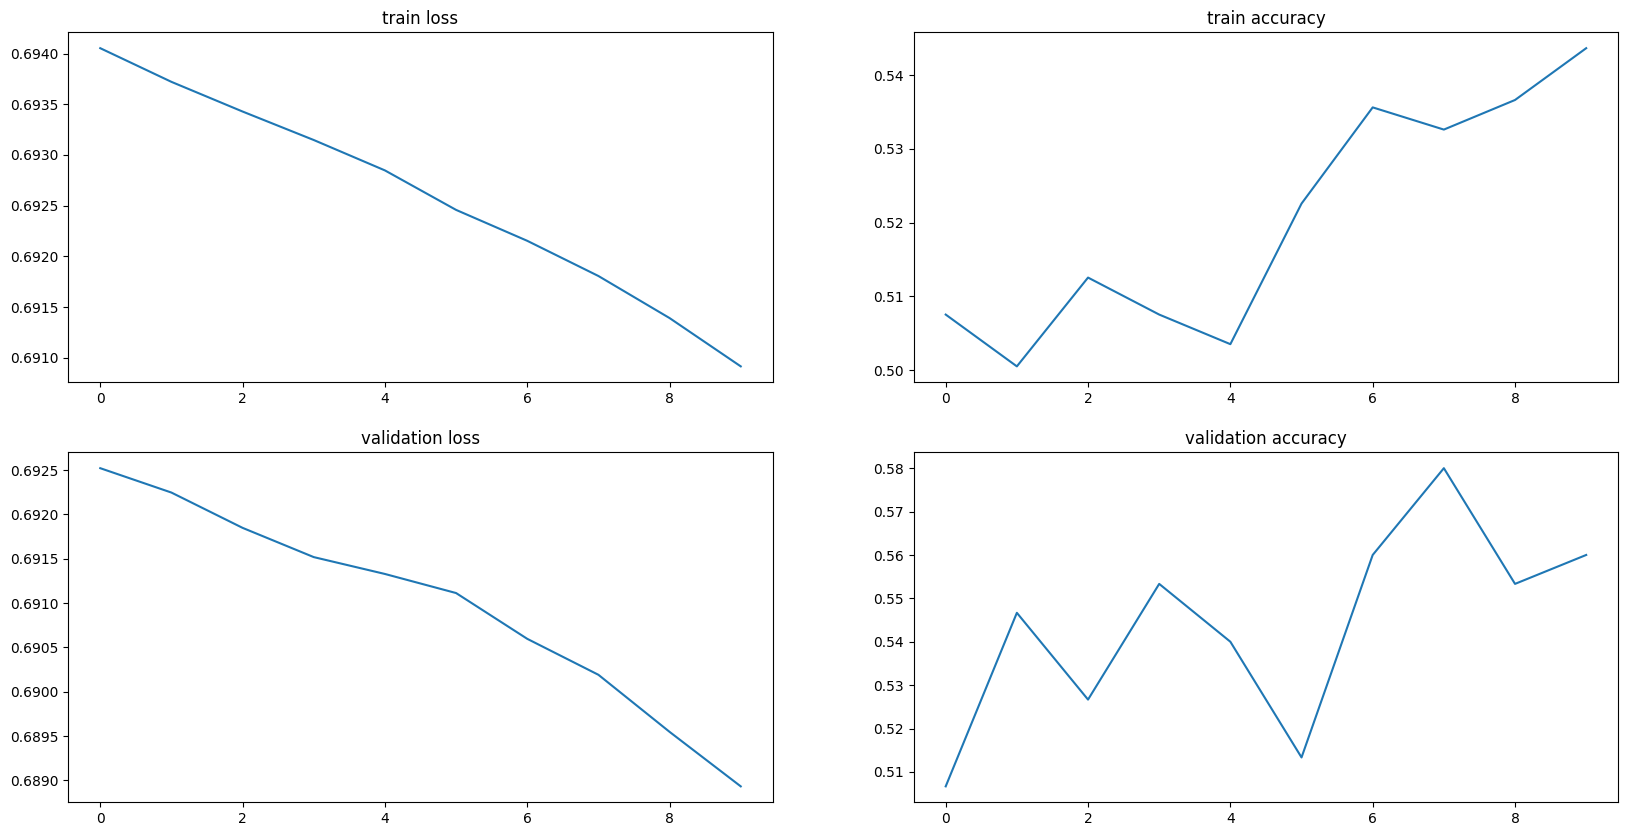

In [12]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN1200SGD.history["loss"])
ax[0][1].plot(historyCNN1200SGD.history["accuracy"])
ax[1][0].plot(historyCNN1200SGD.history["val_loss"])
ax[1][1].plot(historyCNN1200SGD.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [13]:
y_predCNN_SGD_1200 = CNN_1200_SGD.predict(shuffled_test_images[:50])
binary_predictions = np.where(y_predCNN_SGD_1200 > 0.5, 1, 0)
report = classification_report(shuffled_test_labels[:50,0], binary_predictions)
print("Classification Report:")
print(report)


2/2 [==============================] - 1s 142ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.43      0.87      0.58        23
         1.0       0.25      0.04      0.06        27

    accuracy                           0.42        50
   macro avg       0.34      0.45      0.32        50
weighted avg       0.34      0.42      0.30        50



Creating a model with *Adam* as an optimizer

In [14]:
CNN_1200_Adam = create_cnn_model(
    inShape= train_images_1200.shape[1:],
    convNum= [4,4,4,4],
    hNum = [400],
    hAct = 'relu',
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 38, 38, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 19, 19, 4)        

In [15]:

import wandb
run = wandb.init(
    project="CNN_project_Adam",
    config={
        "dataset": "cats and dogs images",
    },
)

historyCNN1200Adam = CNN_1200_Adam.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 10,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = WandbMetricsLogger(),

)

epoch/accuracy,▂▁▃▂▁▅▇▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▅▄▄▃▂▁
epoch/val_accuracy,▁▅▃▅▄▂▆█▅▆
epoch/val_loss,█▇▇▆▆▅▄▃▂▁
epoch/accuracy,0.54363
epoch/epoch,9
epoch/learning_rate,0.01
epoch/loss,0.69091
epoch/val_accuracy,0.56


Epoch 1/10
32/32 [==============================] - 6s 180ms/step - loss: 0.6930 - accuracy: 0.4895 - val_loss: 0.6882 - val_accuracy: 0.5733
Epoch 2/10
32/32 [==============================] - 6s 169ms/step - loss: 0.6816 - accuracy: 0.5898 - val_loss: 0.6712 - val_accuracy: 0.5467
Epoch 3/10
32/32 [==============================] - 5s 163ms/step - loss: 0.6513 - accuracy: 0.6138 - val_loss: 0.6596 - val_accuracy: 0.5667
Epoch 4/10
32/32 [==============================] - 6s 183ms/step - loss: 0.6098 - accuracy: 0.6871 - val_loss: 0.6390 - val_accuracy: 0.6733
Epoch 5/10
32/32 [==============================] - 5s 168ms/step - loss: 0.5826 - accuracy: 0.7001 - val_loss: 0.6465 - val_accuracy: 0.6533
Epoch 6/10
32/32 [==============================] - 5s 161ms/step - loss: 0.5779 - accuracy: 0.6820 - val_loss: 0.6465 - val_accuracy: 0.6133
Epoch 7/10
32/32 [==============================] - 5s 169ms/step - loss: 0.5452 - accuracy: 0.7342 - val_loss: 0.6841 - val_accuracy: 0.5733
Epoch 

In [16]:
y_predCNN_Adam_1200 = CNN_1200_Adam.predict(shuffled_test_images[:50])


binary_predictions = np.where(y_predCNN_Adam_1200 > 0.5, 1, 0)
report = classification_report(shuffled_test_labels[:50,0], binary_predictions)
print("Classification Report:")
print(report)


2/2 [==============================] - 0s 37ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.48      0.61      0.54        23
         1.0       0.57      0.44      0.50        27

    accuracy                           0.52        50
   macro avg       0.53      0.53      0.52        50
weighted avg       0.53      0.52      0.52        50



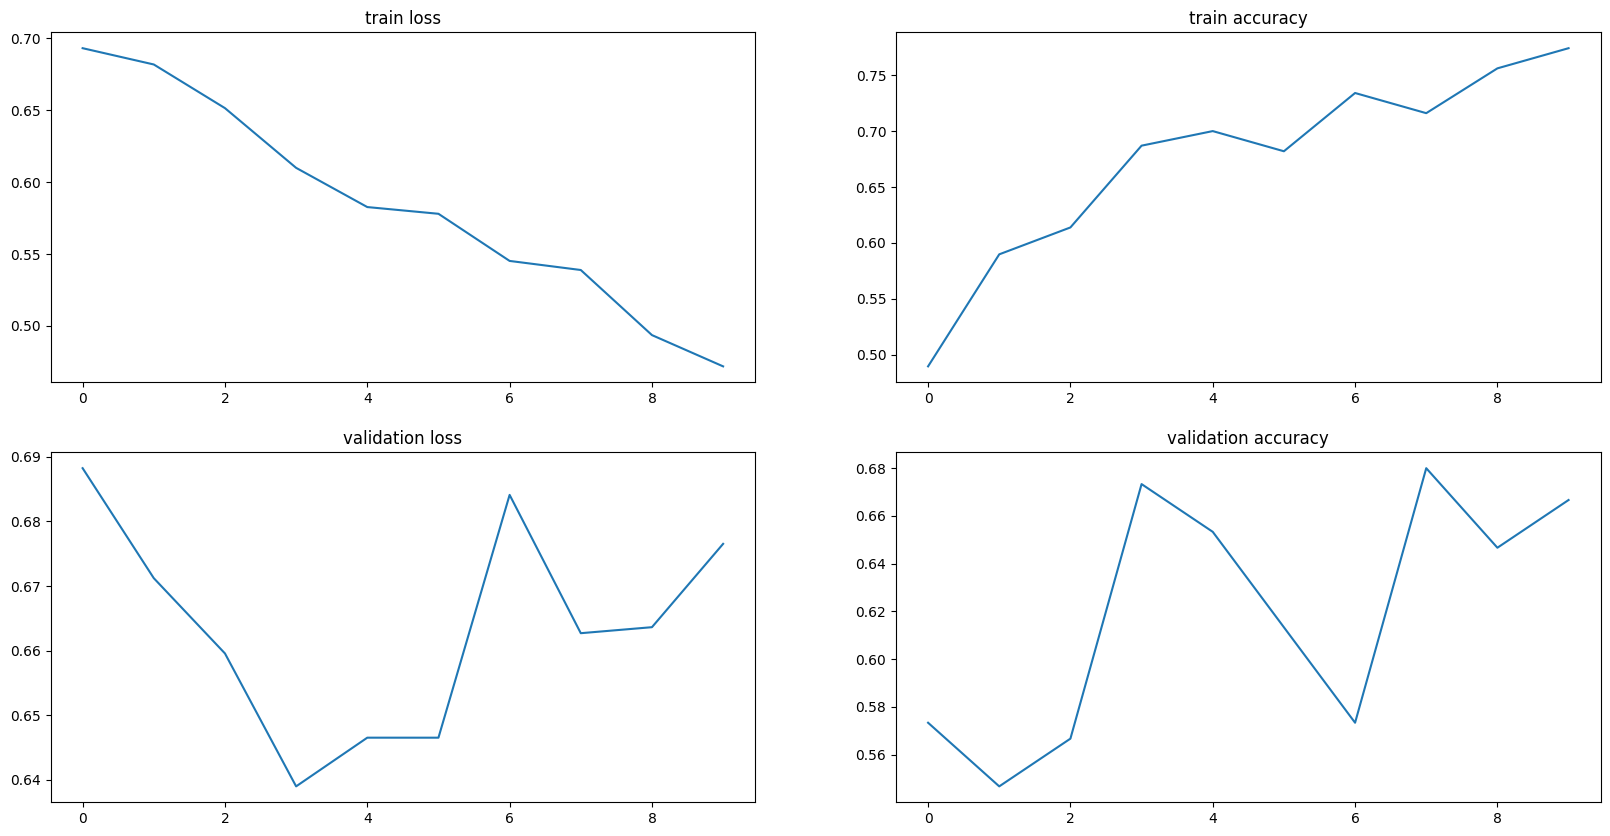

In [17]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN1200Adam.history["loss"])
ax[0][1].plot(historyCNN1200Adam.history["accuracy"])
ax[1][0].plot(historyCNN1200Adam.history["val_loss"])
ax[1][1].plot(historyCNN1200Adam.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

Training the model with an increased number of epochs (100) and Early Stopping callback applied (monintoring validation loss)



In [18]:


early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,         
    verbose = 1,
    mode = "auto",
    #baseline = None,
    restore_best_weights=True 
 ) 

In [19]:
import wandb
run = wandb.init(
    project="CNN_project_Adam_100epochs",
    config={
        "dataset": "cats and dogs images",
    },
)




epoch/accuracy,▁▃▄▆▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▅▅▄▃▃▂▁
epoch/val_accuracy,▂▁▂█▇▅▂█▆▇
epoch/val_loss,█▆▄▁▂▂▇▄▅▆
epoch/accuracy,0.77432
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.4719
epoch/val_accuracy,0.66667


In [20]:

historyCNN1200Adam_100epochs = CNN_1200_Adam.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 100,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = [WandbMetricsLogger(),early_stopping]
                 

)

Epoch 1/100
32/32 [==============================] - 5s 151ms/step - loss: 0.4294 - accuracy: 0.8054 - val_loss: 0.7254 - val_accuracy: 0.6733
Epoch 2/100
32/32 [==============================] - 5s 145ms/step - loss: 0.4168 - accuracy: 0.8144 - val_loss: 0.7333 - val_accuracy: 0.6400
Epoch 3/100
32/32 [==============================] - 5s 144ms/step - loss: 0.3877 - accuracy: 0.8335 - val_loss: 0.7770 - val_accuracy: 0.6333
Epoch 4/100
32/32 [==============================] - 5s 145ms/step - loss: 0.3723 - accuracy: 0.8315 - val_loss: 0.7874 - val_accuracy: 0.6267
Epoch 4: early stopping


Early Stopping with *accuracy* parameter being monitored

In [21]:

early_stopping_accuracy = EarlyStopping(
    monitor='accuracy',  
    patience=3,          
    verbose = 1,
    mode = "auto",
    restore_best_weights=True 
 )

In [22]:
import wandb
run = wandb.init(
    project="CNN_project_Adam_100epochs_ES_acc",
    config={
        "dataset": "cats and dogs images",
    },
)

historyCNN1200Adam_100epochs = CNN_1200_Adam.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 100,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = [WandbMetricsLogger(),early_stopping_accuracy]
                 

)


epoch/accuracy,▁▃██
epoch/epoch,▁▃▆█
epoch/learning_rate,▁▁▁▁
epoch/loss,█▆▃▁
epoch/val_accuracy,█▃▂▁
epoch/val_loss,▁▂▇█
epoch/accuracy,0.83149
epoch/epoch,3
epoch/learning_rate,0.001
epoch/loss,0.37228
epoch/val_accuracy,0.62667


Epoch 1/100
32/32 [==============================] - 5s 151ms/step - loss: 0.4158 - accuracy: 0.8004 - val_loss: 0.7391 - val_accuracy: 0.6533
Epoch 2/100
32/32 [==============================] - 5s 145ms/step - loss: 0.3785 - accuracy: 0.8305 - val_loss: 0.7721 - val_accuracy: 0.6600
Epoch 3/100
32/32 [==============================] - 5s 143ms/step - loss: 0.3585 - accuracy: 0.8405 - val_loss: 0.7977 - val_accuracy: 0.6200
Epoch 4/100
32/32 [==============================] - 5s 143ms/step - loss: 0.3182 - accuracy: 0.8696 - val_loss: 0.8482 - val_accuracy: 0.6267
Epoch 5/100
32/32 [==============================] - 5s 143ms/step - loss: 0.3061 - accuracy: 0.8656 - val_loss: 0.9090 - val_accuracy: 0.6067
Epoch 6/100
32/32 [==============================] - 5s 144ms/step - loss: 0.2909 - accuracy: 0.8716 - val_loss: 0.8988 - val_accuracy: 0.6400
Epoch 7/100
32/32 [==============================] - 5s 147ms/step - loss: 0.2329 - accuracy: 0.9127 - val_loss: 0.9769 - val_accuracy: 0.6267

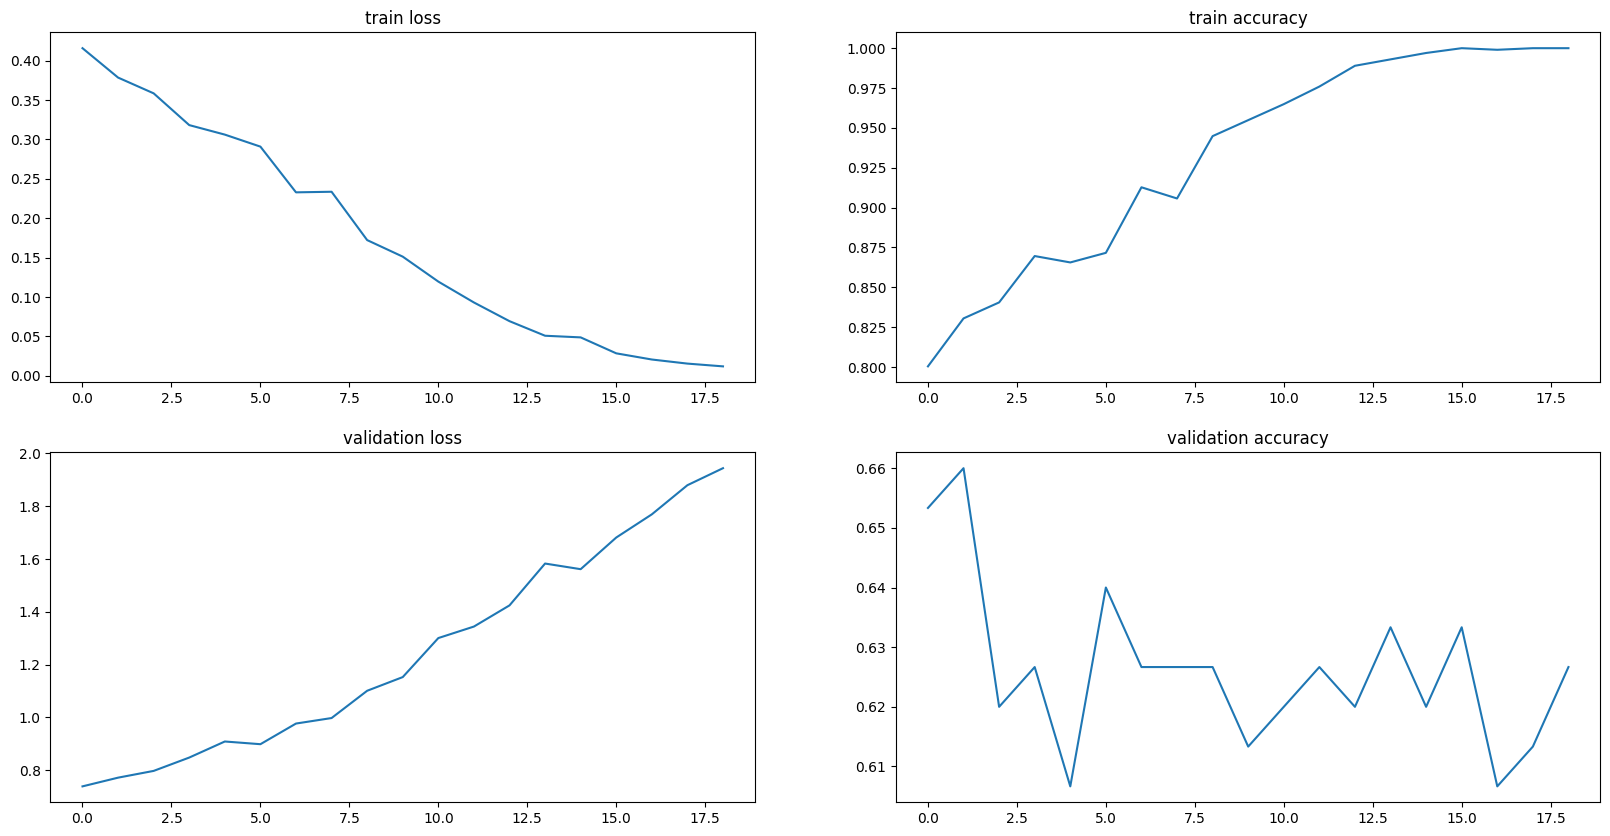

In [23]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN1200Adam_100epochs.history["loss"])
ax[0][1].plot(historyCNN1200Adam_100epochs.history["accuracy"])
ax[1][0].plot(historyCNN1200Adam_100epochs.history["val_loss"])
ax[1][1].plot(historyCNN1200Adam_100epochs.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

Creating a light and fast model

In [24]:
import wandb
run = wandb.init(
    project="CNN_project_the_good_one",
    config={
        "dataset": "cats and dogs images",
    },
)

model_the_light_one = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


epoch/accuracy,▁▂▂▃▃▃▅▅▆▆▇▇███████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▅▅▄▃▃▂▂▂▂▁▁▁▁
epoch/val_accuracy,▇█▃▄▁▅▄▄▄▂▃▄▃▄▃▄▁▂▄
epoch/val_loss,▁▁▁▂▂▂▂▃▃▃▄▅▅▆▆▆▇██
epoch/accuracy,1.0
epoch/epoch,18
epoch/learning_rate,0.001
epoch/loss,0.01202
epoch/val_accuracy,0.62667


In [25]:
model_the_light_one.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'], run_eagerly = True)


history_model_the_light_one = model_the_light_one.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 10,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = WandbMetricsLogger(),

)



Epoch 1/10
32/32 [==============================] - 39s 1s/step - loss: 0.7009 - accuracy: 0.5135 - val_loss: 0.6930 - val_accuracy: 0.4867
Epoch 2/10
32/32 [==============================] - 41s 1s/step - loss: 0.6917 - accuracy: 0.5246 - val_loss: 0.7082 - val_accuracy: 0.4867
Epoch 3/10
32/32 [==============================] - 51s 2s/step - loss: 0.6822 - accuracy: 0.5687 - val_loss: 0.6847 - val_accuracy: 0.5400
Epoch 4/10
32/32 [==============================] - 47s 1s/step - loss: 0.6809 - accuracy: 0.5888 - val_loss: 0.6898 - val_accuracy: 0.5200
Epoch 5/10
32/32 [==============================] - 49s 2s/step - loss: 0.6860 - accuracy: 0.5496 - val_loss: 0.6848 - val_accuracy: 0.5467
Epoch 6/10
32/32 [==============================] - 43s 1s/step - loss: 0.6725 - accuracy: 0.5486 - val_loss: 0.6832 - val_accuracy: 0.5133
Epoch 7/10
32/32 [==============================] - 45s 1s/step - loss: 0.6472 - accuracy: 0.6158 - val_loss: 0.7261 - val_accuracy: 0.5333
Epoch 8/10
32/32 [==

In [26]:
the_light_one_results = model_the_light_one.predict(shuffled_test_images[:50])
binary_predictions = np.where(the_light_one_results > 0.5, 1, 0)
report = classification_report(shuffled_test_labels[:50,0], binary_predictions)
print("Classification Report:")
print(report)

2/2 [==============================] - 1s 169ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.65      0.57        23
         1.0       0.60      0.44      0.51        27

    accuracy                           0.54        50
   macro avg       0.55      0.55      0.54        50
weighted avg       0.55      0.54      0.54        50



Adding *dropout* parameter to see whether it improves the results.

In [27]:
def create_cnn_model_with_dropout(inShape, convNum, hNum, hAct, loss, optimizer, dropout_rate):

    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(inShape)))

    for idx, oneConvNum in enumerate(convNum):

        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=3,
                                    strides=1,
                                    padding="SAME",
                                    activation="relu"
                                    )
                                )

        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )

    model.add(layers.Flatten())

    for idx, oneHidNum in enumerate(hNum):
        model.add(layers.Dense(oneHidNum, activation=hAct))
        model.add(Dropout(rate=dropout_rate))

    model.add(layers.Dense(1, activation = 'sigmoid'))

    # model.add(layers.Softmax())
    print(model.summary())



    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"]
    )

    return model

SGD model with *dropout* 0.1

In [28]:

import wandb
run = wandb.init(
    project="CNN_project_SGD_dropout_0_1",
    config={
        "dataset": "cats and dogs images",
    },
)
modelCNN_SGD_dropout = create_cnn_model_with_dropout(
    inShape= train_images_1200.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.SGD(),
    dropout_rate=0.1
)



historyCNN_SGD_dropout_0_1 = modelCNN_SGD_dropout.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 10,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = [WandbMetricsLogger(), early_stopping_accuracy],

)




epoch/accuracy,▁▁▃▄▃▃▅▅██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▇▆▅▄▁▁
epoch/val_accuracy,▁▁▇▄▇▄▆▅▄█
epoch/val_loss,▂▃▁▁▁▁▄▂██
epoch/accuracy,0.67503
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.59227
epoch/val_accuracy,0.55333


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 75, 75, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 38, 38, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 19, 19, 4)        

SGD model with *dropout* 0.3

In [29]:
import wandb
run = wandb.init(
    project="CNN_project_SGD_dropout_0_3",
    config={
        "dataset": "cats and dogs images",
    },
)
modelCNN_SGD_dropout = create_cnn_model_with_dropout(
    inShape= train_images_1200.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.SGD(),
    dropout_rate=0.3
)



historyCNN_SGD_dropout_0_1 = modelCNN_SGD_dropout.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 10,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = [WandbMetricsLogger(), early_stopping_accuracy],

)

epoch/accuracy,▁▂▄▄▄▅█▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▅▄▃▂▂▁▁
epoch/val_accuracy,▃▁▄▃▅▃▆▆▇█
epoch/val_loss,▇█▇▆▆▅▄▃▂▁
epoch/accuracy,0.58676
epoch/epoch,9
epoch/learning_rate,0.01
epoch/loss,0.68581
epoch/val_accuracy,0.58667


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 75, 75, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 38, 38, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 19, 19, 4)        

Adam model with *dropout* 0.1

In [30]:

import wandb
run = wandb.init(
    project="CNN_project_Adam_dropout_0_1",
    config={
        "dataset": "cats and dogs images",
    },
)
modelCNN_Adam_dropout = create_cnn_model_with_dropout(
    inShape= train_images_1200.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
    dropout_rate=0.1
)



historyCNN_Adam_dropout_0_1 = modelCNN_Adam_dropout.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 10,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = [WandbMetricsLogger(), early_stopping_accuracy],

)

epoch/accuracy,▂▃▂▁▅▁▁█▂▆
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▆▄▂▄▄▁▃▄
epoch/val_accuracy,▄▄▄▃▄▁▂▄▅█
epoch/val_loss,█▆▆▄▂▄▅▂▁▂
epoch/accuracy,0.51755
epoch/epoch,9
epoch/learning_rate,0.01
epoch/loss,0.69288
epoch/val_accuracy,0.54667


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 75, 75, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 38, 38, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 19, 19, 4)        

Adam model with *dropout* 0.3

In [31]:
import wandb
run = wandb.init(
    project="CNN_project_Adam_dropout_0_3",
    config={
        "dataset": "cats and dogs images",
    },
)
modelCNN_SGD_dropout = create_cnn_model_with_dropout(
    inShape= train_images_1200.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
    dropout_rate=0.3
)


historyCNN_SGD_dropout_0_1 = modelCNN_SGD_dropout.fit(
    x = train_images_1200,
    y = train_labels_1200[:,0],
    epochs = 10,
    validation_data = (shuffled_test_images[50:], shuffled_test_labels[50:,0]),
    callbacks = [WandbMetricsLogger(), early_stopping_accuracy],

)


epoch/accuracy,▁▄▄▅▄▆▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▃▂▁
epoch/val_accuracy,▂▁▅▇▅▅▇██▇
epoch/val_loss,▂▁▃▆▂▅▄▅▄█
epoch/accuracy,0.79137
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.46239
epoch/val_accuracy,0.62667


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 75, 75, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 38, 38, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 19, 19, 4)        

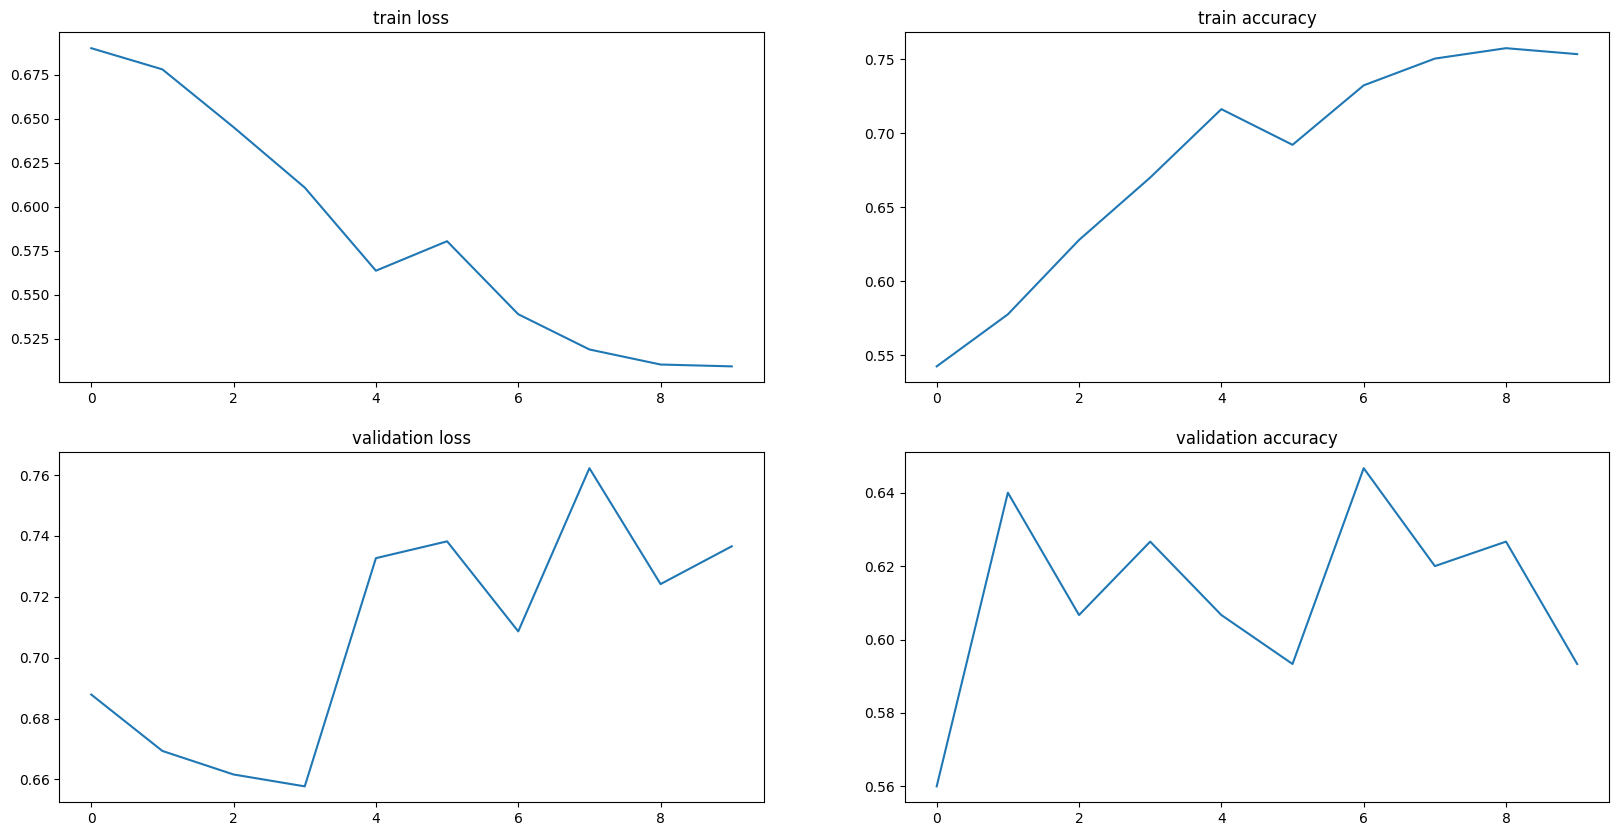

In [32]:

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN_SGD_dropout_0_1.history["loss"])
ax[0][1].plot(historyCNN_SGD_dropout_0_1.history["accuracy"])
ax[1][0].plot(historyCNN_SGD_dropout_0_1.history["val_loss"])
ax[1][1].plot(historyCNN_SGD_dropout_0_1.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

DATA AUGMENTATION

In [33]:



datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [-20, 20] degrees
    width_shift_range=0.2,  # Random horizontal shift by 20% of the width
    height_shift_range=0.2, # Random vertical shift by 20% of the height
    shear_range=0.2,        # Random shear transformation by 20%
    zoom_range=0.2,         # Random zoom by 20%
    horizontal_flip=True,   # Random horizontal flipping
    fill_mode='nearest'     # Fill mode for points outside the input boundaries
)



In [34]:
# Fit the data generator to your training data
datagen.fit(train_images_1200)

model = create_cnn_model(
    inShape=train_images_1200.shape[1:],
    convNum=[4, 4, 4, 4],
    hNum=[400],
    hAct='relu',
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam()
)

# Train the model using the data generator
history_augmented_Adam = model.fit(
    datagen.flow(train_images_1200, train_labels_1200[:, 0], batch_size=32),
    epochs=10,
    validation_data=(test_images_1200, test_labels_1200[:, 0])
)



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 75, 75, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 38, 38, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 19, 19, 4)        

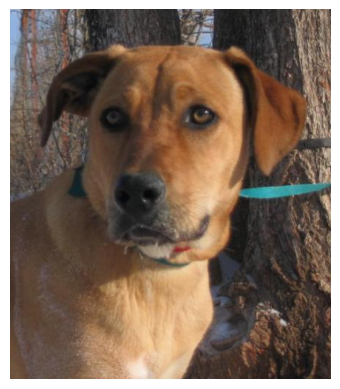

In [35]:
img = cv2.imread("/home/kata/zajecia/ćwiczenia_python_moje/projekt_DL/data_1200/training/dogs/51.jpg")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()


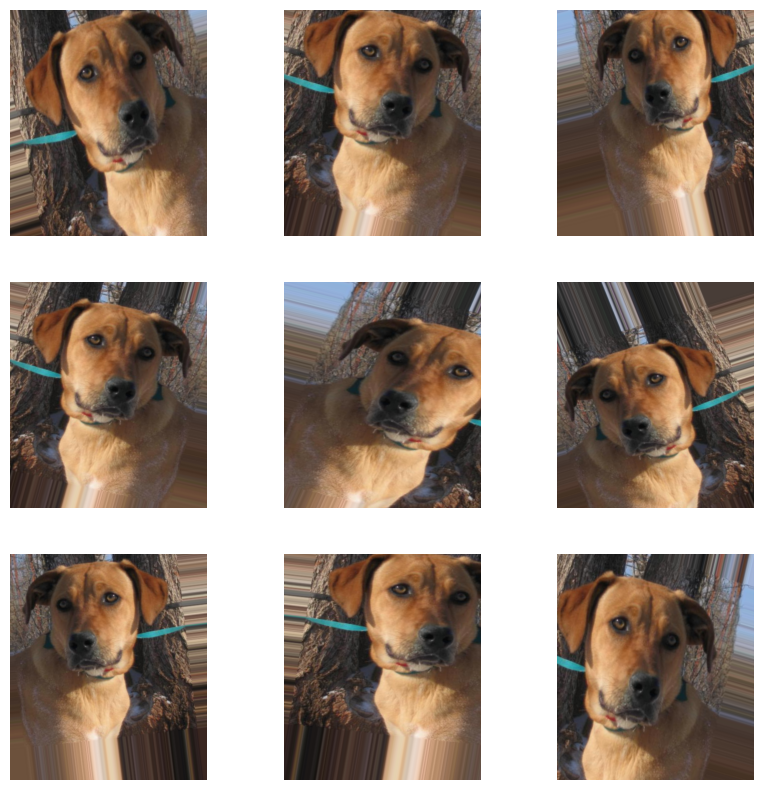

In [36]:
img_array = np.expand_dims(img_rgb, axis=0)
augmented_images = datagen.flow(img_array, batch_size=1)


plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = augmented_images.next()[0].astype('uint8')
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.show()

In [37]:
model = create_cnn_model(
    inShape=train_images_1200.shape[1:],
    convNum=[4, 4, 4, 4],
    hNum=[400],
    hAct='relu',
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.SGD()
)

# Train the model using the data generator
history_augmented_SGD = model.fit(
    datagen.flow(train_images_1200, train_labels_1200[:, 0], batch_size=32),
    epochs=10,
    validation_data=(test_images_1200, test_labels_1200[:, 0])
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 75, 75, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 38, 38, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 19, 19, 4)        

TRANSFER LEARNING

The subsequent phase entails transfer learning, wherein the classification of cats and dogs relies on a pre-trained network. This pre-trained model, trained on an extensive dataset, serves as a versatile model suitable for various classification tasks, such as the categorization of cats and dogs in this scenario. Several base models have been designated, including MobileNetV2, MobileNetV3Large and VGG16.

In [38]:
add_test_images_1200, add_test_vectors_1200, add_test_labels_1200 = load_images(add_test_dir_1200)

In [39]:

resized_train1200images = tf.image.resize(train_images_1200, (224, 224)).numpy()
resized_test1200images = tf.image.resize(test_images_1200, (224, 224)).numpy()
resized_addtest1200images = tf.image.resize(add_test_images_1200, (224,224)).numpy()


In [40]:
np.random.seed(42)
np.random.shuffle(resized_test1200images)
np.random.seed(42)
np.random.shuffle(test_labels_1200)

shuffled_resized_test_images = np.copy(resized_test1200images)
shuffled_resized_test_labels = np.copy(test_labels_1200)


Creating transfer learning model with Mobile Net V3 Large as a base model

In [41]:
inputLayer = tf.keras.Input(shape =resized_test1200images.shape[1:] )

base_model = tf.keras.applications.MobileNetV3Large(

    weights='imagenet', 
    input_shape= resized_test1200images.shape[1:],
    include_top=False)


Setting base_model trainable as False to prevent the risk of overfitting or forgetting previously learned features.

In [42]:
base_model.trainable = False

Adding last layers

In [43]:
# adding last layers
x = base_model(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

In [44]:
# model with MobileNetV3Large as a base_model
model = tf.keras.Model(inputLayer, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_18 (Dense)            (None, 1)                 961       
                                                                 
Total params: 2997313 (11.43 MB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________


In [45]:

opt_Adam.build(model.trainable_variables)

In [46]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
    run_eagerly=True
)

Creating a model with V3Large as a base model and learning_rate = 0.01 and 0.001

In [47]:
# Access the learning rate attribute of the optimizer
default_learning_rate = tf.keras.optimizers.Adam().learning_rate.numpy()

print("Default learning rate:", default_learning_rate)

Default learning rate: 0.001


In [48]:
learning_rate = 0.01

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
    run_eagerly=True
)



import wandb
run = wandb.init(
    project="transfer_learning_V3",
    config={
        "dataset": "cats and dogs images",
    },
)

historyTF_V3 = model.fit(
    resized_train1200images,
    train_labels_1200[:,0],
    epochs=10,
    validation_data= (shuffled_resized_test_images[50:], shuffled_resized_test_labels[50:,0]),
    callbacks = WandbMetricsLogger(),
)

epoch/accuracy,▁▂▄▅▇▆▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▆▅▃▄▂▁▁▁
epoch/val_accuracy,▁▇▅▆▅▄█▆▆▄
epoch/val_loss,▃▂▁▁▆▆▄█▅▆
epoch/accuracy,0.75326
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.5093
epoch/val_accuracy,0.59333


Epoch 1/10
32/32 [==============================] - 105s 3s/step - loss: 0.7093 - accuracy: 0.5015 - val_loss: 0.6982 - val_accuracy: 0.5067
Epoch 2/10
32/32 [==============================] - 111s 3s/step - loss: 0.7051 - accuracy: 0.4995 - val_loss: 0.6877 - val_accuracy: 0.5067
Epoch 3/10
32/32 [==============================] - 107s 3s/step - loss: 0.6939 - accuracy: 0.5176 - val_loss: 0.7392 - val_accuracy: 0.5067
Epoch 4/10
32/32 [==============================] - 107s 3s/step - loss: 0.7054 - accuracy: 0.5125 - val_loss: 0.6981 - val_accuracy: 0.5200
Epoch 5/10
32/32 [==============================] - 100s 3s/step - loss: 0.6844 - accuracy: 0.5547 - val_loss: 0.6803 - val_accuracy: 0.5933
Epoch 6/10
32/32 [==============================] - 96s 3s/step - loss: 0.6817 - accuracy: 0.5827 - val_loss: 0.6941 - val_accuracy: 0.5400
Epoch 7/10
32/32 [==============================] - 96s 3s/step - loss: 0.6811 - accuracy: 0.5677 - val_loss: 0.6834 - val_accuracy: 0.5533
Epoch 8/10
32/3

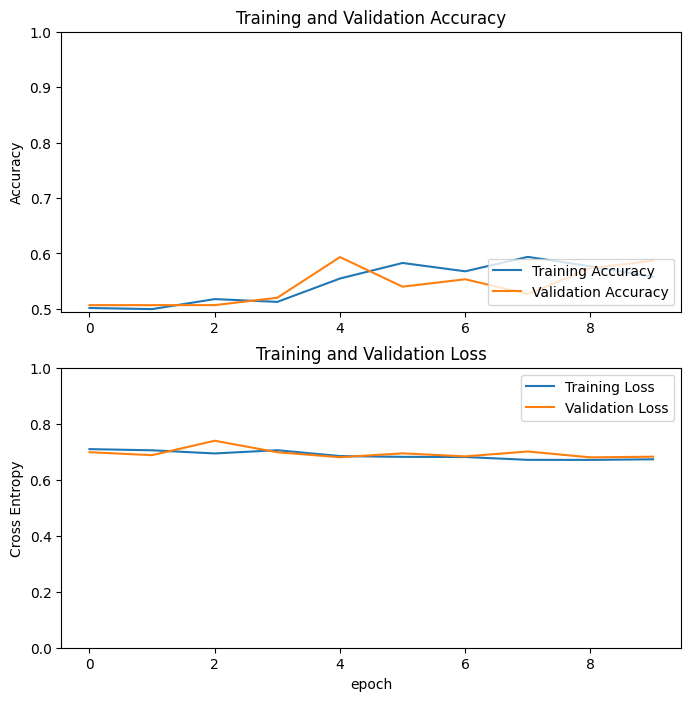

In [49]:
acc = historyTF_V3.history['accuracy']
val_acc = historyTF_V3.history['val_accuracy']

loss = historyTF_V3.history['loss']
val_loss = historyTF_V3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
yTF_V3_0_01_pred = model.predict(resized_addtest1200images)
binary_predictions = np.where(yTF_V3_0_01_pred > 0.5, 1, 0)
report = classification_report(add_test_labels_1200[:,0], binary_predictions)

print(report)


5/5 [==============================] - 4s 710ms/step
              precision    recall  f1-score   support

         0.0       0.78      0.47      0.58        75
         1.0       0.62      0.87      0.72        75

    accuracy                           0.67       150
   macro avg       0.70      0.67      0.65       150
weighted avg       0.70      0.67      0.65       150



In [51]:
#v3 with default learning rate

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
    run_eagerly=True
)



import wandb
run = wandb.init(
    project="transfer_learning_V3 default learning rate 0.001",
    config={
        "dataset": "cats and dogs images",
    },
)

historyTF_V3_0_001 = model.fit(
    resized_train1200images,
    train_labels_1200[:,0],
    epochs=10,
    validation_data= (shuffled_resized_test_images[50:], shuffled_resized_test_labels[50:,0]),
    callbacks = WandbMetricsLogger(),
)

epoch/accuracy,▁▁▂▂▅▇▆█▇▅
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▇▃▃▃▁▁▁
epoch/val_accuracy,▁▁▁▂█▄▅▃▆▇
epoch/val_loss,▃▂█▃▁▃▁▃▁▁
epoch/accuracy,0.55767
epoch/epoch,9
epoch/learning_rate,0.01
epoch/loss,0.67294
epoch/val_accuracy,0.58667


Epoch 1/10
32/32 [==============================] - 88s 3s/step - loss: 0.6616 - accuracy: 0.6138 - val_loss: 0.6759 - val_accuracy: 0.5800
Epoch 2/10
32/32 [==============================] - 88s 3s/step - loss: 0.6597 - accuracy: 0.6229 - val_loss: 0.6760 - val_accuracy: 0.5800
Epoch 3/10
32/32 [==============================] - 89s 3s/step - loss: 0.6592 - accuracy: 0.6289 - val_loss: 0.6763 - val_accuracy: 0.5667
Epoch 4/10
32/32 [==============================] - 89s 3s/step - loss: 0.6593 - accuracy: 0.6148 - val_loss: 0.6778 - val_accuracy: 0.5467
Epoch 5/10
32/32 [==============================] - 90s 3s/step - loss: 0.6584 - accuracy: 0.6229 - val_loss: 0.6758 - val_accuracy: 0.5933
Epoch 6/10
32/32 [==============================] - 88s 3s/step - loss: 0.6615 - accuracy: 0.6118 - val_loss: 0.6772 - val_accuracy: 0.5600
Epoch 7/10
32/32 [==============================] - 88s 3s/step - loss: 0.6579 - accuracy: 0.6189 - val_loss: 0.6759 - val_accuracy: 0.5867
Epoch 8/10
32/32 [==

In [52]:
yTF_V3_0_001_pred = model.predict(resized_addtest1200images)
binary_predictions = np.where(yTF_V3_0_001_pred > 0.5, 1, 0)
report = classification_report(add_test_labels_1200[:,0], binary_predictions)

print(report)


5/5 [==============================] - 5s 910ms/step
              precision    recall  f1-score   support

         0.0       0.71      0.52      0.60        75
         1.0       0.62      0.79      0.69        75

    accuracy                           0.65       150
   macro avg       0.67      0.65      0.65       150
weighted avg       0.67      0.65      0.65       150



Creating transfer learning model with Mobile Net V2 as a base model

In [53]:
inputLayer = tf.keras.Input(shape =resized_test1200images.shape[1:] )


base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(

    weights='imagenet', 
    input_shape= resized_test1200images.shape[1:],
    include_top=False)

base_model.trainable = False


x = base_model(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputLayer, output)
model.summary()

# optimizer = tf.keras.optimizers.legacy.Adam
opt_Adam.build(model.trainable_variables)

model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
    run_eagerly=True
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [54]:

import wandb
run = wandb.init(
    project="transfer_learning_V2",
    config={
        "dataset": "cats and dogs images",
    },
)

historyTF_V2 = model.fit(
    resized_train1200images,
    train_labels_1200[:,0],
    epochs=10,
    validation_data= (shuffled_resized_test_images[50:], shuffled_resized_test_labels[50:,0]),
    callbacks = WandbMetricsLogger(),
)

epoch/accuracy,▄▆█▄▆▃▅▅▇▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▄▂█▁▃▄▂
epoch/val_accuracy,▆▆▄▁█▃▇▁▃▃
epoch/val_loss,▁▂▂▇▁▅▁▆▂█
epoch/accuracy,0.60281
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.65832
epoch/val_accuracy,0.56


Epoch 1/10
32/32 [==============================] - 115s 4s/step - loss: 0.3272 - accuracy: 0.8826 - val_loss: 0.1456 - val_accuracy: 0.9533
Epoch 2/10
32/32 [==============================] - 103s 3s/step - loss: 0.1098 - accuracy: 0.9679 - val_loss: 0.1073 - val_accuracy: 0.9667
Epoch 3/10
32/32 [==============================] - 104s 3s/step - loss: 0.0796 - accuracy: 0.9769 - val_loss: 0.0968 - val_accuracy: 0.9667
Epoch 4/10
32/32 [==============================] - 103s 3s/step - loss: 0.0626 - accuracy: 0.9850 - val_loss: 0.0910 - val_accuracy: 0.9667
Epoch 5/10
32/32 [==============================] - 107s 3s/step - loss: 0.0520 - accuracy: 0.9900 - val_loss: 0.0957 - val_accuracy: 0.9733
Epoch 6/10
32/32 [==============================] - 107s 3s/step - loss: 0.0445 - accuracy: 0.9920 - val_loss: 0.0865 - val_accuracy: 0.9667
Epoch 7/10
32/32 [==============================] - 110s 3s/step - loss: 0.0391 - accuracy: 0.9930 - val_loss: 0.0874 - val_accuracy: 0.9667
Epoch 8/10
32

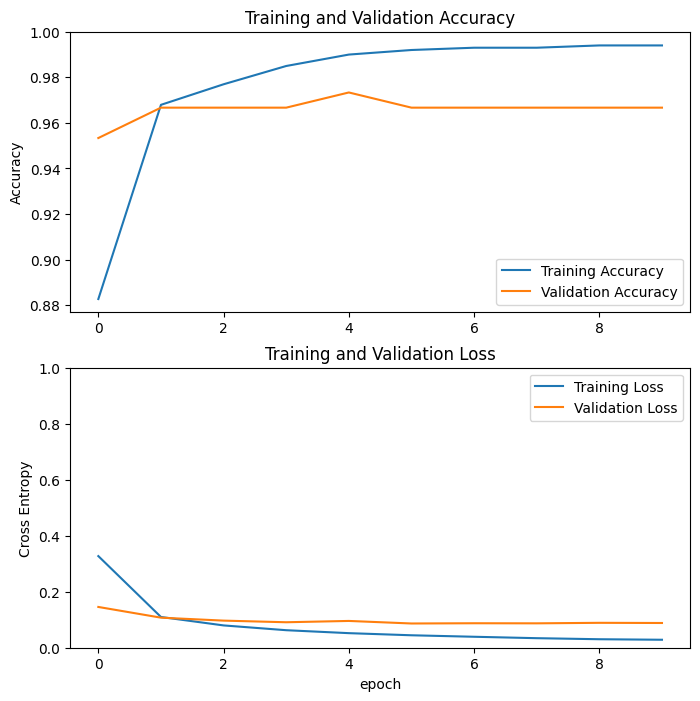

In [55]:
acc = historyTF_V2.history['accuracy']
val_acc = historyTF_V2.history['val_accuracy']

loss = historyTF_V2.history['loss']
val_loss = historyTF_V2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
yTF_V2_pred = model.predict(resized_addtest1200images)
binary_predictions = np.where(yTF_V2_pred > 0.5, 1, 0)
report = classification_report(add_test_labels_1200[:,0], binary_predictions)
print("Classification Report:")
print(report)

5/5 [==============================] - 4s 691ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        75
         1.0       0.99      0.97      0.98        75

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



Creating transfer learning model with VGG16 as a base model

In [57]:
inputLayer = tf.keras.Input(shape =resized_test1200images.shape[1:] )


base_model = tf.keras.applications.VGG16(

    weights='imagenet', 
    input_shape= resized_test1200images.shape[1:],
    include_top=False)

base_model.trainable = False


x = base_model(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputLayer, output)
model.summary()

# optimizer = tf.keras.optimizers.legacy.Adam
opt_Adam.build(model.trainable_variables)

model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
    run_eagerly=True
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [58]:

import wandb
run = wandb.init(
    project="transfer_learning_VGG16",
    config={
        "dataset": "cats and dogs images",
    },
)

historyTF_VGG16 = model.fit(
    resized_train1200images,
    train_labels_1200[:,0],
    epochs=10,
    validation_data= (shuffled_resized_test_images[50:], shuffled_resized_test_labels[50:,0]),
    callbacks = WandbMetricsLogger(),
)


epoch/accuracy,▁▆▇▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▆▆▆█▆▆▆▆▆
epoch/val_loss,█▃▂▂▂▁▁▁▁▁
epoch/accuracy,0.99398
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.02847
epoch/val_accuracy,0.96667


Epoch 1/10
32/32 [==============================] - 997s 31s/step - loss: 0.6933 - accuracy: 0.5617 - val_loss: 0.6764 - val_accuracy: 0.5733
Epoch 2/10
32/32 [==============================] - 990s 31s/step - loss: 0.6502 - accuracy: 0.6921 - val_loss: 0.6552 - val_accuracy: 0.6733
Epoch 3/10
32/32 [==============================] - 993s 31s/step - loss: 0.6256 - accuracy: 0.7141 - val_loss: 0.6388 - val_accuracy: 0.6800
Epoch 4/10
32/32 [==============================] - 1030s 32s/step - loss: 0.5999 - accuracy: 0.7462 - val_loss: 0.6231 - val_accuracy: 0.7467
Epoch 5/10
32/32 [==============================] - 991s 31s/step - loss: 0.5786 - accuracy: 0.7964 - val_loss: 0.6064 - val_accuracy: 0.7467
Epoch 6/10
32/32 [==============================] - 990s 31s/step - loss: 0.5593 - accuracy: 0.8185 - val_loss: 0.5935 - val_accuracy: 0.7667
Epoch 7/10
32/32 [==============================] - 992s 31s/step - loss: 0.5418 - accuracy: 0.8395 - val_loss: 0.5824 - val_accuracy: 0.7533
Epoch

In [59]:
yTF_VGG16_pred = model.predict(resized_addtest1200images)

5/5 [==============================] - 47s 9s/step


In [60]:
binary_predictions = np.where(yTF_VGG16_pred > 0.5, 1, 0)
report = classification_report(add_test_labels_1200[:,0], binary_predictions)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86        75
         1.0       0.85      0.88      0.86        75

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150



The analysis provided below represents the initial examination, conducted on a training set comprising 100 images, with a testing set of 30 images. However, the outcomes derived from this smaller dataset were found to be unsatisfactory. Therefore, the analysis presented above was undertaken to reassess the findings.

In [61]:
data_folder = '/home/kata/zajecia/ćwiczenia_python_moje/projekt_DL/data_100'

In [62]:
train_dir = os.path.join(data_folder, 'training')
test_dir = os.path.join(data_folder, 'testing')

In [63]:

train_images, train_vectors, train_labels = load_images(train_dir)
test_images, test_vectors, test_labels = load_images(test_dir)

batch_size = 20
img_size = (150, 150)


In [64]:
train_images.shape

(150, 150, 150, 3)

In [65]:
train_vectors.shape

(150, 67500)

In [66]:
train_labels.shape

(150, 2)

In [67]:
opt_SGD

Creating a simple ANN model 

In [68]:
def define_model(input_shape, hidden_units, activation):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Dense(hidden_units, activation=activation, name="hidden"),
        layers.Dense(1, activation='sigmoid', name="output")
    ])
    return model


def compile_model(model, optimizer):
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])


input_shape = train_vectors.shape[1]
hidden_units = 10
activation = 'relu'
optSGD = tf.keras.optimizers.legacy.SGD()

modelANN_SGD = define_model(input_shape, hidden_units, activation)
compile_model(modelANN_SGD, optSGD)



In [69]:
opt_Adam.build(model.trainable_variables)
opt_SGD.build(model.trainable_variables)

In [70]:
# Train the model
historyANN_SGD = modelANN_SGD.fit(train_vectors, train_labels[:,0], batch_size=20, epochs=10, verbose=2, validation_split=0.05)


Epoch 1/10
8/8 - 1s - loss: 1.3436 - accuracy: 0.4859 - val_loss: 0.6911 - val_accuracy: 1.0000 - 1s/epoch - 137ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6933 - accuracy: 0.4718 - val_loss: 0.6899 - val_accuracy: 1.0000 - 72ms/epoch - 9ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6934 - accuracy: 0.4718 - val_loss: 0.6909 - val_accuracy: 1.0000 - 74ms/epoch - 9ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6933 - accuracy: 0.4718 - val_loss: 0.6920 - val_accuracy: 1.0000 - 66ms/epoch - 8ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6933 - accuracy: 0.4718 - val_loss: 0.6930 - val_accuracy: 1.0000 - 100ms/epoch - 13ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6931 - accuracy: 0.5141 - val_loss: 0.6940 - val_accuracy: 0.0000e+00 - 72ms/epoch - 9ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6932 - accuracy: 0.4577 - val_loss: 0.6927 - val_accuracy: 1.0000 - 61ms/epoch - 8ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6932 - accuracy: 0.4437 - val_loss: 0.6960 - val_accuracy: 0.0000e+00 - 77ms/epoch - 10ms/step
Epoch 9/10
8/8 - 0s - loss: 0

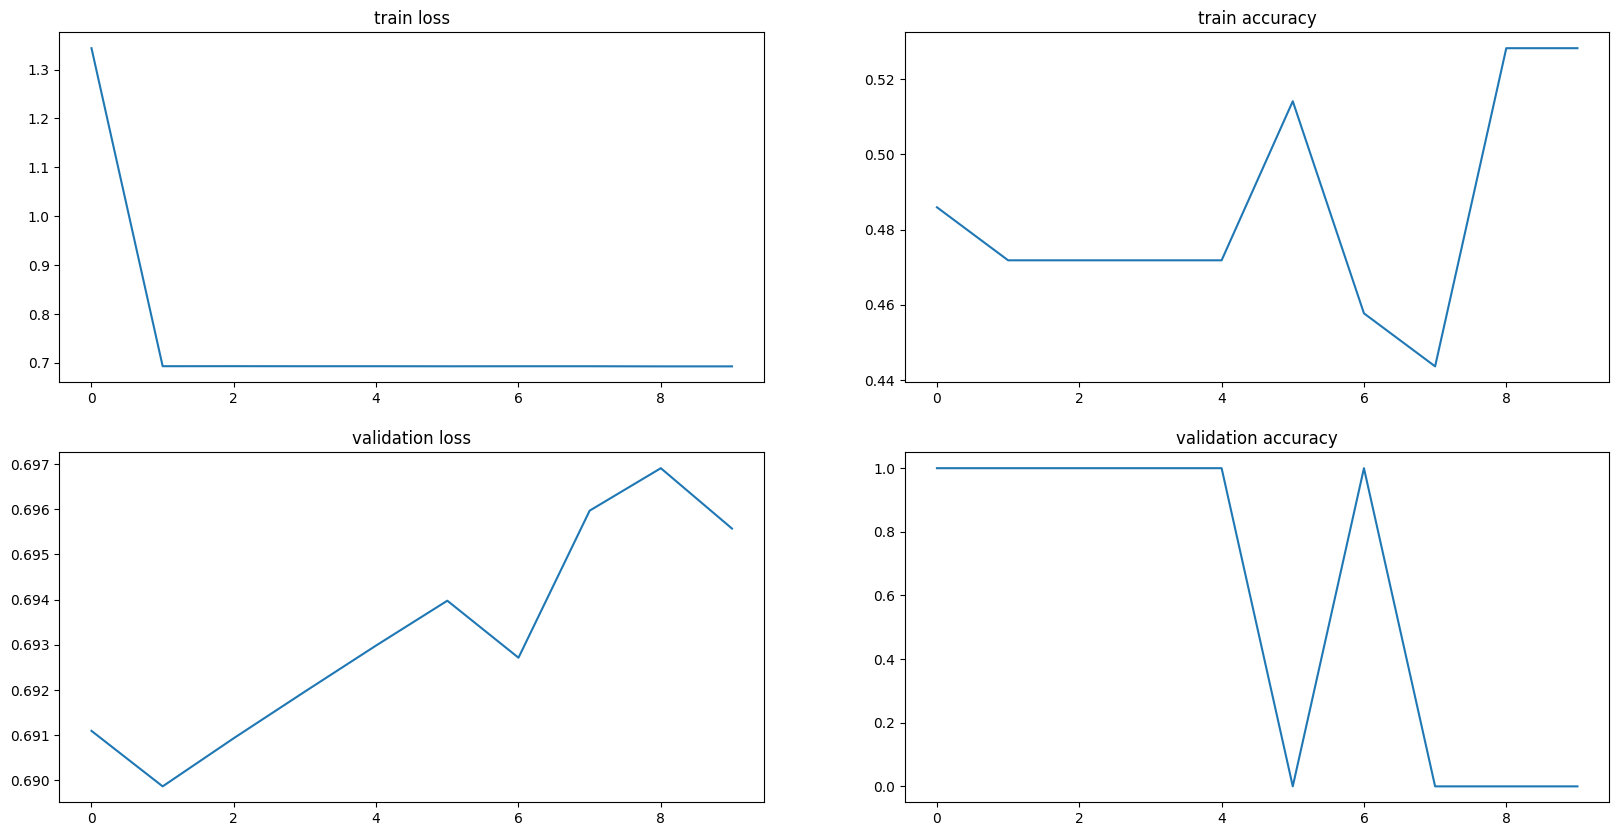

In [71]:

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyANN_SGD.history["loss"])
ax[0][1].plot(historyANN_SGD.history["accuracy"])
ax[1][0].plot(historyANN_SGD.history["val_loss"])
ax[1][1].plot(historyANN_SGD.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()



In [72]:
y_predANN_SGD = modelANN_SGD.predict(test_vectors)
y_predANN_SGD

binary_predictions = np.where(y_predANN_SGD > 0.5, 1, 0)
report = classification_report(test_labels[:,0], binary_predictions)
print("Classification Report:")
print(report)




2/2 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        30
         1.0       0.00      0.00      0.00        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



/home/kata/apps/anaconda3/envs/python_intro/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kata/apps/anaconda3/envs/python_intro/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kata/apps/anaconda3/envs/python_intro/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [73]:
modelCNN_Adam = create_cnn_model(
    inShape=train_images.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam()
)

historyCNN_Adam = modelCNN_Adam.fit(
    x= train_images,
    y=train_labels[:,0],
    batch_size=60,
    epochs=10,
    validation_split=0.05,
    verbose=0
)




Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 75, 75, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 38, 38, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 19, 19, 4)       

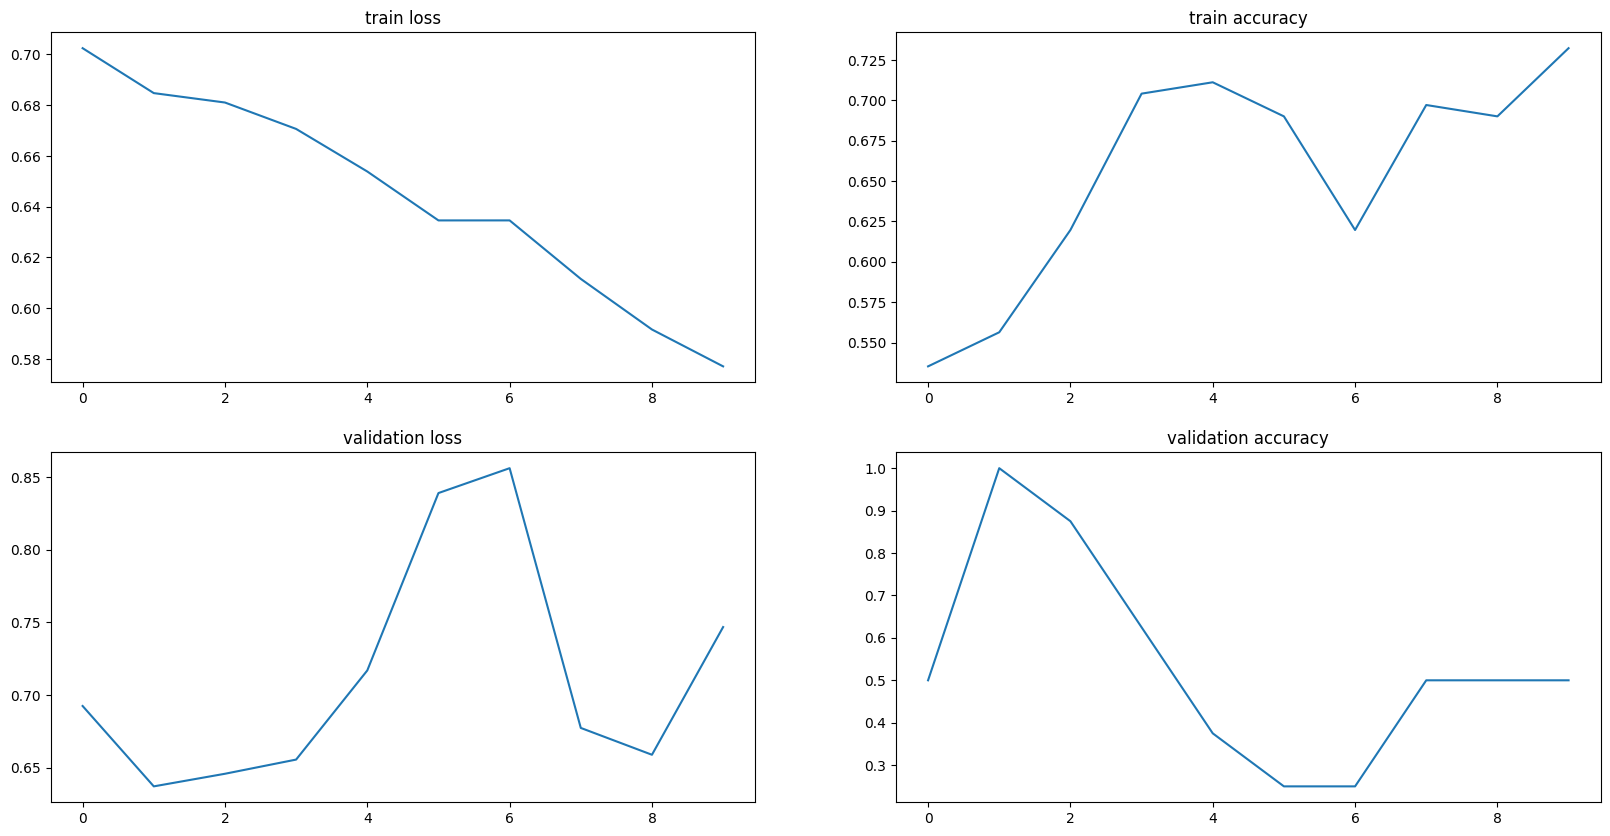

In [74]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN_Adam.history["loss"])
ax[0][1].plot(historyCNN_Adam.history["accuracy"])
ax[1][0].plot(historyCNN_Adam.history["val_loss"])
ax[1][1].plot(historyCNN_Adam.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()




In [75]:

y_pred_CNN_Adam = modelCNN_Adam.predict(test_images)
binary_predictions = np.where(y_pred_CNN_Adam > 0.5, 1, 0)
report = classification_report(test_labels[:,0], binary_predictions)
print("Classification Report:")
print(report)



2/2 [==============================] - 0s 49ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.73      0.66        30
         1.0       0.65      0.50      0.57        30

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.61        60
weighted avg       0.62      0.62      0.61        60



In [76]:
modelCNN_SGD = create_cnn_model(
    inShape=train_images.shape[1:],
    convNum=[4,4,4,4],
    hNum=[400],
    hAct="relu",
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.SGD()
)

historyCNN_SGD = modelCNN_SGD.fit(
    x= train_images,
    y=train_labels[:,0],
    batch_size=20,
    epochs=10,
    validation_split=0.05)



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 150, 150, 4)       112       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 75, 75, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 75, 75, 4)         148       
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 38, 38, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 38, 38, 4)         148       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 19, 19, 4)       

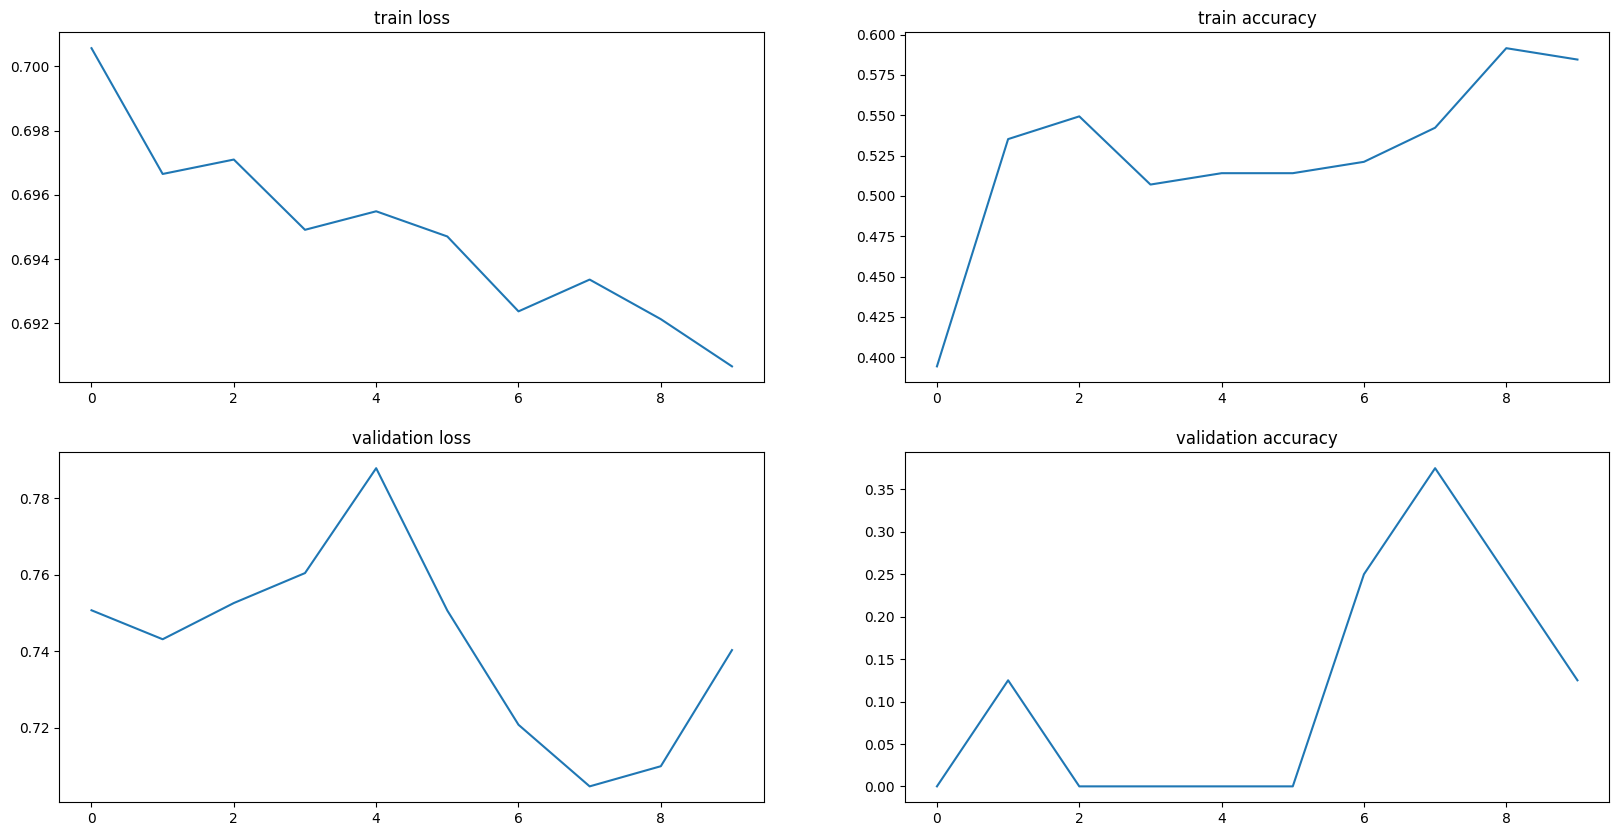

In [77]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

ax[0][0].plot(historyCNN_SGD.history["loss"])
ax[0][1].plot(historyCNN_SGD.history["accuracy"])
ax[1][0].plot(historyCNN_SGD.history["val_loss"])
ax[1][1].plot(historyCNN_SGD.history["val_accuracy"])

ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [78]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo

Number of CPU:  4
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 78
model name	: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz
stepping	: 3
microcode	: 0xf0
cpu MHz		: 2799.548
cache size	: 3072 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 22
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb invpcid_single pti ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid mpx rdseed adx smap clflushopt intel_pt xsaveopt x